In [1]:
from nltk import pos_tag
import nltk
import pandas as pd

In [2]:
df = pd.read_csv('../data/source_data.csv', usecols=['Word', 'Number in hard mode'])
df.head()

,Word,Number in hard mode
0,slump,1362
1,crank,1763
2,gorge,1913
3,query,2242
4,drink,3017


# 音节统计

In [ ]:
from curses.ascii import isdigit
from nltk.corpus import cmudict

def nsyl(word):
    d = cmudict.dict()
    return max([len([y for y in x if isdigit(y[-1])]) for x in d[word.lower()]])

df['syllable'] = 0
for i in range(len(df)):
    print('processing: ', i, '/', len(df))
    try:
        df.iloc[i, 2] = nsyl(df.iloc[i, 0])
    except KeyError:
        df.iloc[i, 2] = 0
df

In [10]:
nsyl('eerie')

2

# 词频统计

In [4]:
# 只读取 RANK # 列， word 列和 TOTAL列
word_fre_list = pd.read_excel('../data/word frequency list 60000 English.xlsx', usecols=[0, 1, 2, 3], index_col=0)
word_fre_list.head()
# df 添加新列 frequency， 每一项的值都是 0
df['frequency'] = 0
for i in range(len(df)):
    df.iloc[i, 2] = word_fre_list[word_fre_list['WORD'] == '  '+df.iloc[i, 0]]['TOTAL'].sum()
    if df.iloc[i, 2] == 0:
        df.iloc[i, 2] = word_fre_list[word_fre_list['WORD'] == '  (' + df.iloc[i, 0]+')']['TOTAL'].sum()



ValueError: x and y must have same first dimension, but have shapes (12,) and (360,)

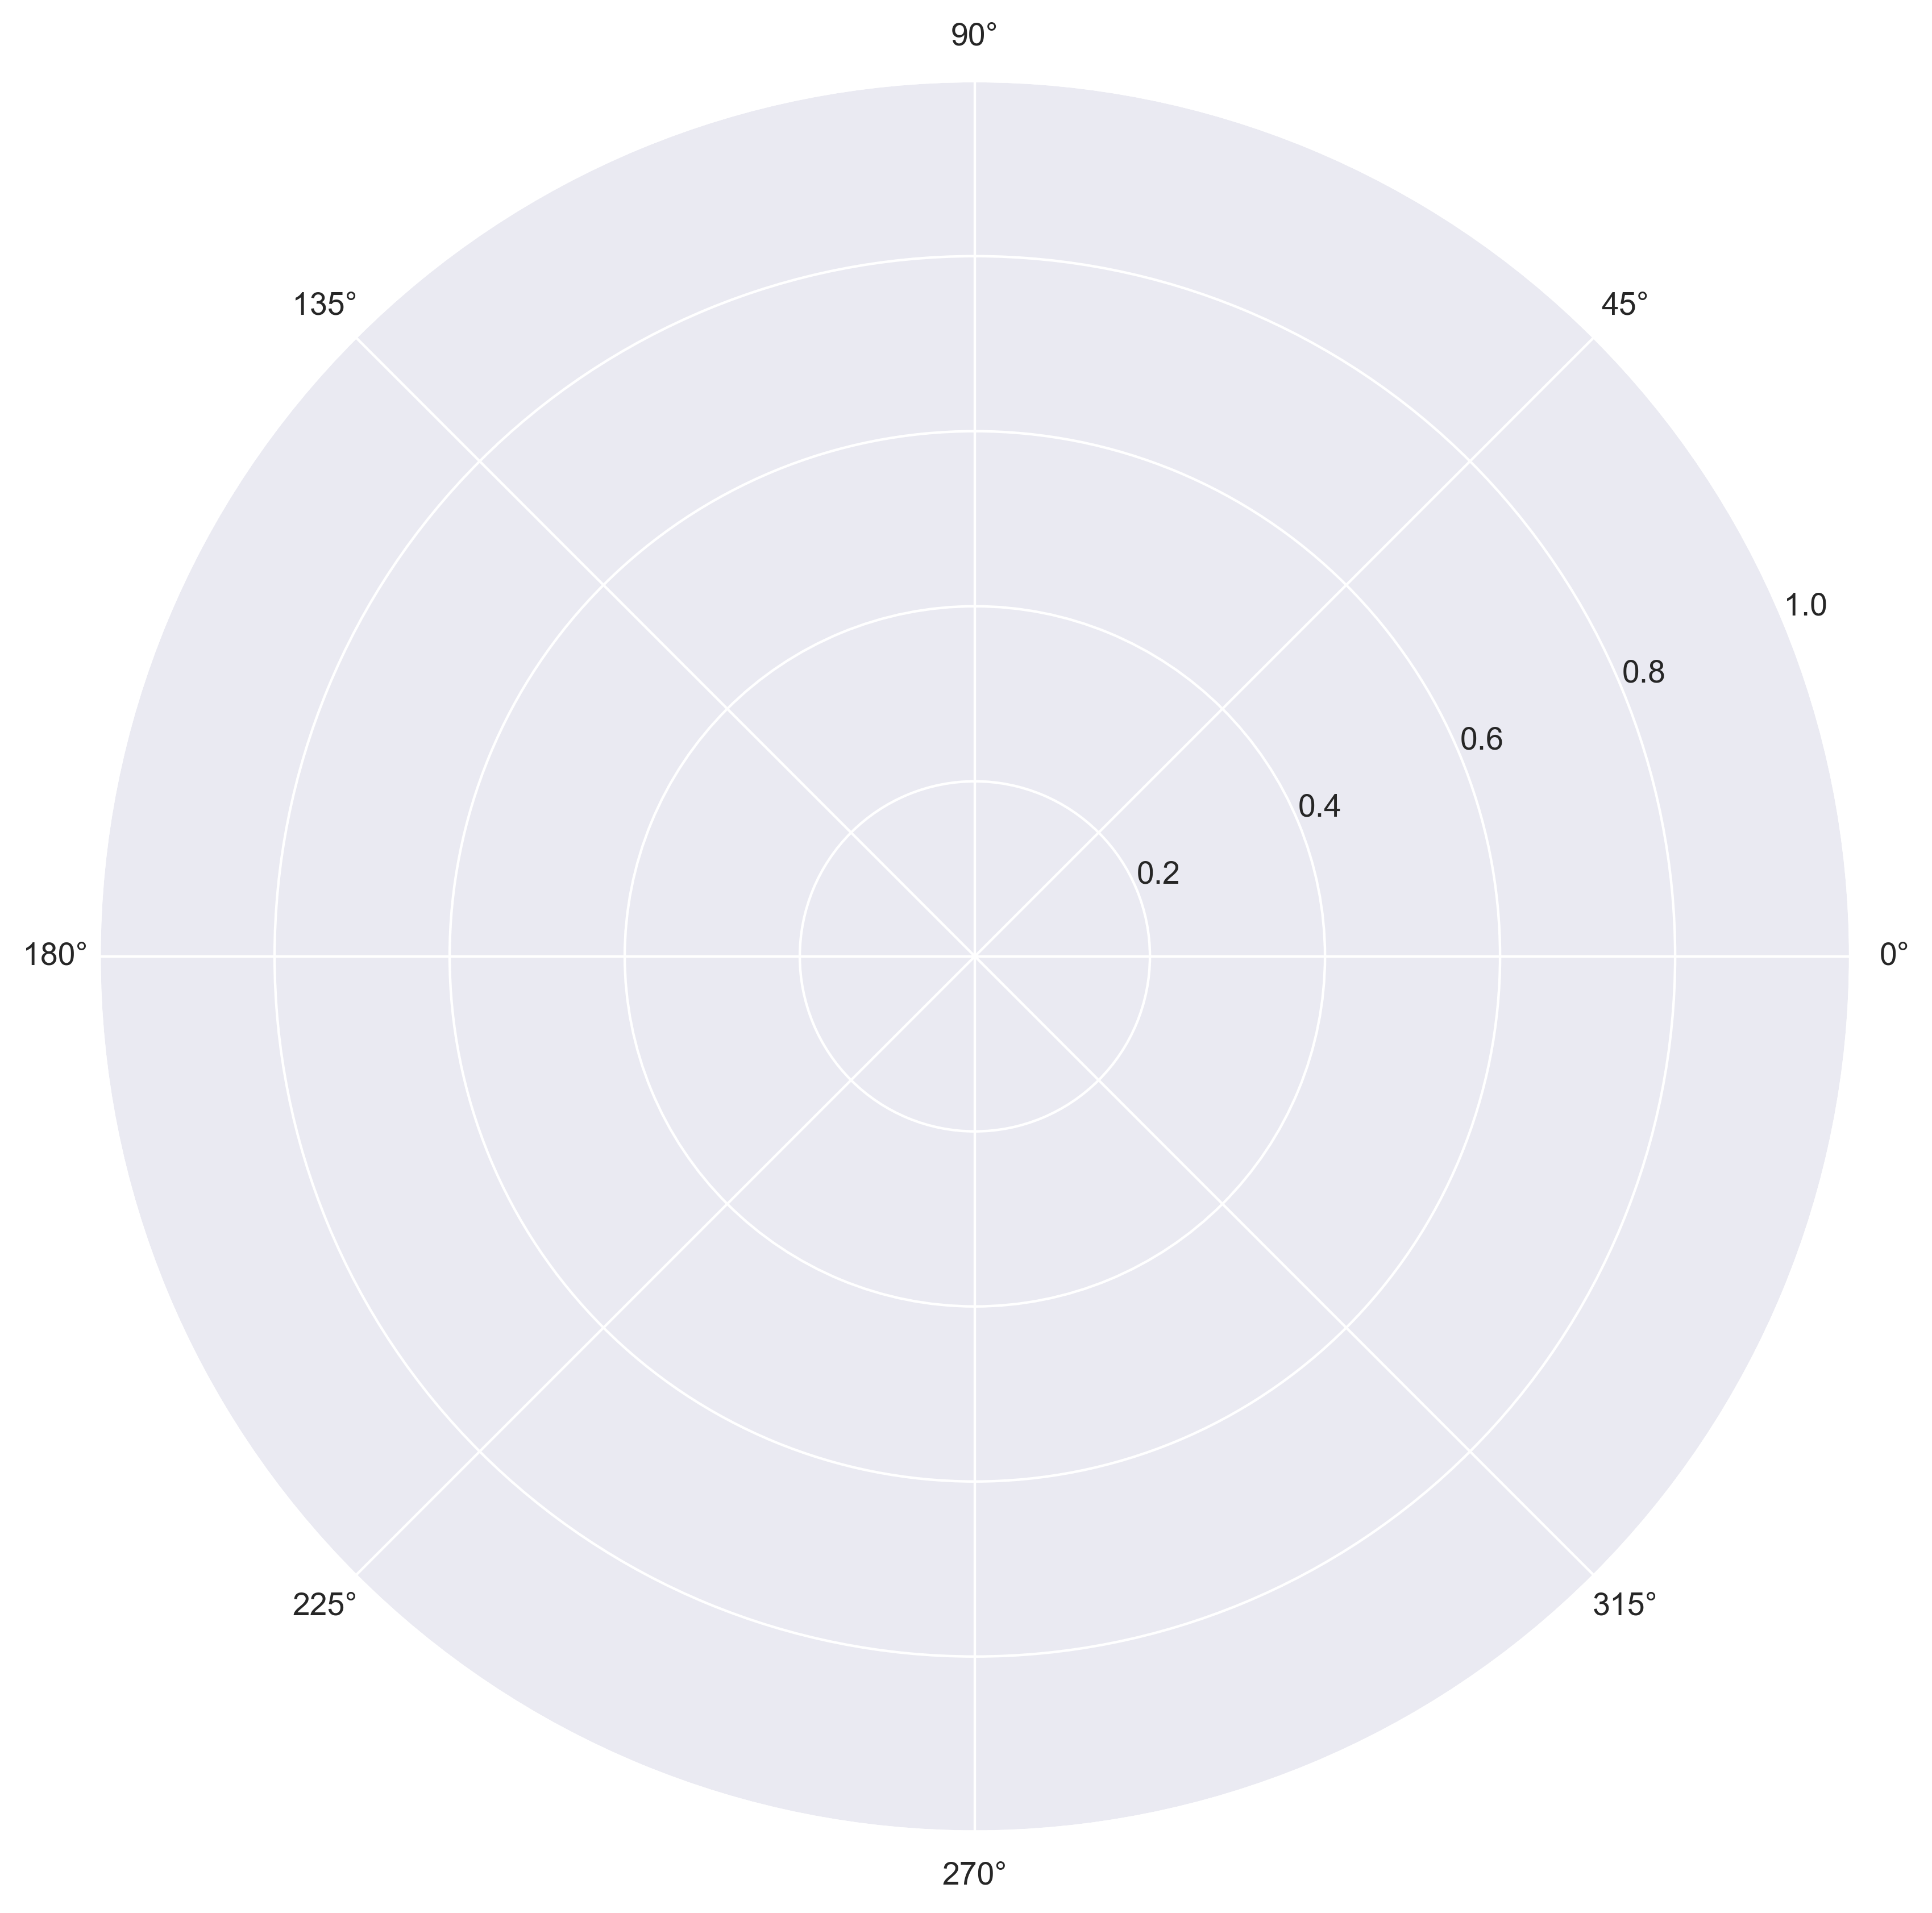

# 词性标注

In [8]:

words = df['Word'].tolist()
tags = pos_tag(words)

df['tag'] = 0
for i in range(len(df)):
    df.iloc[i, 4] = tags[i][1]

df['tag'] = df['tag'].astype('category')
df['tag'] = df['tag'].cat.codes

In [11]:
pos_tag(['eerie'])

[('eerie', 'NN')]

In [9]:
df.to_csv('../data/handle_data.csv', index=False)

# 相关性分析

In [84]:
# 将tag列量化
df['tag'] = df['tag'].astype('category')
df['tag'] = df['tag'].cat.codes

In [77]:
# 将 syllable frequency tag 归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['syllable', 'frequency', 'tag']] = scaler.fit_transform(df[['syllable', 'frequency', 'tag']])

In [92]:
# 将 Number in hard mode 整体向前移动一位，多余的补0
shift_ = 0
df['Number in hard mode'] = df['Number in hard mode'].shift(-shift_)
# 将 syllable frequency tag 三列作为特征， number in hard mode 作为标签，进行相关性分析，不管后面 shift_ 个单词
map_data = df.loc[:len(df)-shift_, ['syllable', 'frequency', 'tag', 'Number in hard mode']].corr()

In [ ]:
# 画出相关性热力图
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10), dpi=400)
sns.heatmap(map_data, annot=True, vmax=1, square=True, cmap="Reds")
plt.savefig('../pic/heatmap.png', dpi=400)
plt.show()

In [96]:
map_data.to_csv('../data/map_data.csv')